define space as a big 3D array (dimensions L, L, and H) of Booleans (filled or not), and ditto surface (surface or not)

In [48]:
#!pip install -q bitarray
import bitarray as ba

In [49]:
from matplotlib import pyplot as plt

In [50]:
L=50
H=250

space = [[ba.bitarray(H) for y in range(L)] for x in range(L)]

surface = [[ba.bitarray(H) for y in range(L)] for x in range(L)]

for i in range(L):
    for j in range(L):
        space[i][j].setall(0)
        surface[i][j].setall(0)

write a method initializeTip that plonks a cylindrical wire down into space and intializes the surface (later want to add crystal-boundary defects as voids in the space that aren't classified as surface)

In [51]:
def initializeTip(r):
    for i in range(-L//2,L//2+1):
        for j in range(-L//2,L//2+1):
            #start by wiping out previous settings
            space[L//2+i-1][L//2+j-1].setall(0)
            surface[L//2+i-1][L//2+j-1].setall(0)
            
            if (i**2+j**2)<=r**2:
                space[L//2+i-1][L//2+j-1].setall(1)

                #add the bottom cell to the surface
                surface[L//2+i-1][L//2+j-1][H-1]=1

                #check if on the boundary and if so add to surface
                if ((i+1)**2+j**2)>r**2 or ((i-1)**2+j**2)>r**2 or (i**2+(j+1)**2)>r**2 or (i**2+(j-1)**2)>r**2:
                    surface[L//2+i-1][L//2+j-1].setall(1)
                

In [52]:
initializeTip(L//2-2)

Set up etch parameters: water level in space below which etching occurs, function from local radius of curvature to etch probability at the surface, and etch-rate milestones at which to save the state during etching.

In [53]:
#alpha is the negative exponent of the radius of curvature. (about 1.2 from MMAJ Voncken et al, 2002)
#but we're actually going to pass in 1/radius of curvature.

#cR is the coefficient of the radius of curvature part relative to the constant term
#p0 is the overall scale factor on etch rate, which is also the etch probability for a flat plane

alpha=1.2
p0=0.12
cR=10

def p(rInv):
    if(rInv>0):
        return p0*(1+cR*rInv**alpha)
    else:
        return p0*(1-cR*(-rInv)**alpha)

In [54]:
print(p(0),p(0.05),p(0.15),p(0.3),p(0.5))

0.12 0.1529568162991835 0.24316597720535368 0.4029611108147842 0.6423303379776745


Estimate inverse radius of curvature by assuming that if there's lots of nearby material, the curvature is roughly cylindrical, and if it's extreme, the curvature is roughly spherical. If the nearby material is more than half solid, return a negative number.

In [55]:
LCur=7
#searching out to a radius-7 ball, there are 1419 possible sites. If we're sitting on the surface, about 784
# sites will be filled.

#define water level based on LCur
wLevel=LCur+1

def nSpace(x,y,z):
    #just a piece of finding curvature, where we find the number of solid points within a sphere of radius LCur
    #if near the boundaries, find the safe indices to search over, otherwise search out to LCur
    if x-LCur<0:
        xMin=-x
    else:
        xMin=-LCur

    if x+LCur>=L:
        xMax=L-x
    else:
        xMax=LCur+1

    if y-LCur<0:
        yMin=-y
    else:
        yMin=-LCur

    if y+LCur>=L:
        yMax=L-y
    else:
        yMax=LCur+1

    if z-LCur<0:
        zMin=-z
    else:
        zMin=-LCur

    if z+LCur>=H:
        zMax=H-z
    else:
        zMax=LCur+1

    #prepare to count the number of solid points
    nSpace=0

    for i in range(xMin,xMax):
        for j in range(yMin,yMax):
            for k in range(zMin,zMax):
                if(i**2+j**2+k**2<=LCur**2):
                    if space[x+i][y+j][z+k]:
                        nSpace+=1

    return nSpace

Generate empirical data for curvature estimation by checking nSpace for tips of different sizes. Goal is for the estimated curvature to match the actual cylinder radius.

In [56]:
def reportNSpace():
    n=0
    total=0
    for i in range(-L//2,L//2+1):
        for j in range(-L//2,L//2+1):
            if surface[L//2+i-1][L//2+j-1][0]:
                #check if on the boundary and if so add nS at midpoint to total
                n+=1
                total+=nSpace(L//2+i-1,L//2+j-1,H//2)
     
    if n>0:
        return total/n
    else:
        return 0

In [57]:
radii=[]
for i in range(1,L//2-1):
    initializeTip(i)
    n=reportNSpace()
    print(n,i)
    radii.append(n)

67.0 1
170.0 2
350.5 3
494.8 4
575.4285714285714 5
611.625 6
632.0 7
656.5454545454545 8
669.9166666666666 9
685.9285714285714 10
691.7333333333333 11
696.8125 12
706.1666666666666 13
709.4736842105264 14
717.047619047619 15
719.5909090909091 16
723.375 17
726.8 18
727.8846153846154 19
732.8214285714286 20
733.8620689655172 21
736.0 22
738.15625 23


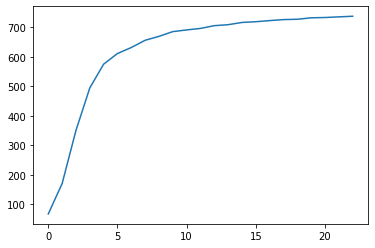

In [58]:
plt.plot(radii)
plt.show()

Try to fit the inverse of this with a function that start like x^2 or x^3 and ends like A-B/x^2

In [59]:
A=2.8
B=776.8
C=698
E=0.9328
Xd=470
Dd=300
#Also storing a parameter (max possible cells) for later use:
MaxN=1419

#Fitting (C/(B-x)**E) to the data from x=690 to x=750 gives C=698, B=776.8, E=0.9328

def fit(x):
    return ((x**0.38/A)*(1+3/Dd)**(Xd-x)+(C/(B-x)**E)*(1+3/Dd)**(x-Xd))/((1+3/Dd)**(x-Xd)+(1+3/Dd)**(Xd-x))

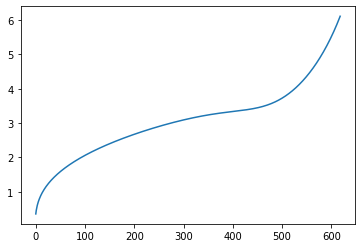

In [60]:
fits=[]
for i in range(1,620):
    fits.append(fit(i))
    
plt.plot(fits)
plt.show()

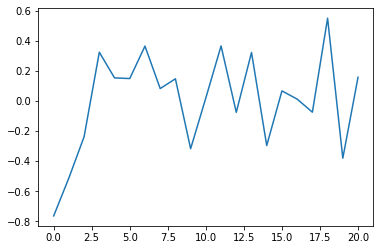

In [61]:
errs=[]
for i in range(0,L//2-4):
    errs.append(i+1-fit(radii[i]))
    
plt.plot(errs)
plt.show()

In [62]:
def curvature(x,y,z):
    if surface[x][y][z]:
        nS=nSpace(x,y,z)
        
        #If nSpace>B (the parameter from fit() function), set a flag and flip them
        flipped=False
        if nS>B:
            flipped=True
            nS = 2*B - nS
            
        #Use semi-empirical fit to get radius of curvature from nS
        curv=1/fit(nS)
                
        #If flipped, flip the sign
        if flipped:
            curv*=-1
        
        return curv
    else:
        return 0

Main etching simulation loop. Track the amount of mass removed at each timestep, and save the state of space when the amount passes the determined thresholds, ending after the last one.

In [63]:
import numpy as np
import random
from IPython.display import clear_output

In [64]:
def saveProj(array):
    #takes space and saves a 2d projection in the right format to be imaged with matplotlib
    proj=np.zeros((H,L),dtype="int")

    for x in range(L):
        for z in range(H):
            for y in range(L):
                proj[z][x]+=array[x][y][z]
    
    return proj

In [65]:
milestones=[0.9,0.7,0.5,0.4,0.3,0.2,0.15,0.1,0.05]

In [67]:
#milestones
tempMiles = milestones.copy()

#emergency time parameter in case I miss a stop condition
t=0
maxT=1000

firstRate=0

eroded=0

savedProjs=[]

while t<maxT and len(tempMiles)>0:
    #track progress by printing t at the end and clearing at the start.
    clear_output(wait=True)
    
    t+=1
    rate=0
    
    toErode=[]
    
    for x in range(L):
        for y in range(L):
            for z in range(wLevel,H):
                if surface[x][y][z]:
                    #with probability p(curv), add this site to a list of sites to erode
                    if random.random()<p(curvature(x,y,z)):
                        rate+=1
                        toErode.append((x,y,z))
                        
    for coords in toErode:
        x=coords[0]
        y=coords[1]
        z=coords[2]
        
        #remove this site from surface and space, and promote adjacent filled cells to surface
        surface[x][y][z]=0
        space[x][y][z]=0
        
        #check surrounding space for resurfacing, accounting for edge cases near array edge
        if x==0:
            if space[x+1][y][z]:
                surface[x+1][y][z]=1
        elif x==L-1:
            if space[x-1][y][z]:
                surface[x-1][y][z]=1
        else:
            for dx in [-1,1]:
                if space[x+dx][y][z]:
                    surface[x+dx][y][z]=1

        if y==0:
            if space[x][y+1][z]:
                surface[x][y+1][z]=1
        elif y==L-1:
            if space[x][y-1][z]:
                surface[x][y-1][z]=1
        else:
            for dy in [-1,1]:
                if space[x][y+dy][z]:
                    surface[x][y+dy][z]=1

        if z==0:
            if space[x][y][z+1]:
                surface[x][y][z+1]=1
        elif z==H-1:
            if space[x][y][z-1]:
                surface[x][y][z-1]=1
        else:
            for dz in [-1,1]:
                if space[x][y][z+dz]:
                    surface[x][y][z+dz]=1
                                    
    if t==1 or rate>firstRate:
        firstRate=rate
    elif rate/firstRate < tempMiles[0]: #as rate drops below milestones, remove the milestones and save the projs.
        savedProjs.append(saveProj(space))
        tempMiles.pop(0)
            
    eroded+=rate
            
    print("t=",t, ", cells removed: ", eroded, "(", 100*eroded/(L**2*H), "%) ", ", milestones left: ",len(tempMiles))

t= 1000 , cells removed:  310640 ( 0.497024 %)  , milestones left:  0


Visualize the saved tips

<Figure size 432x288 with 0 Axes>

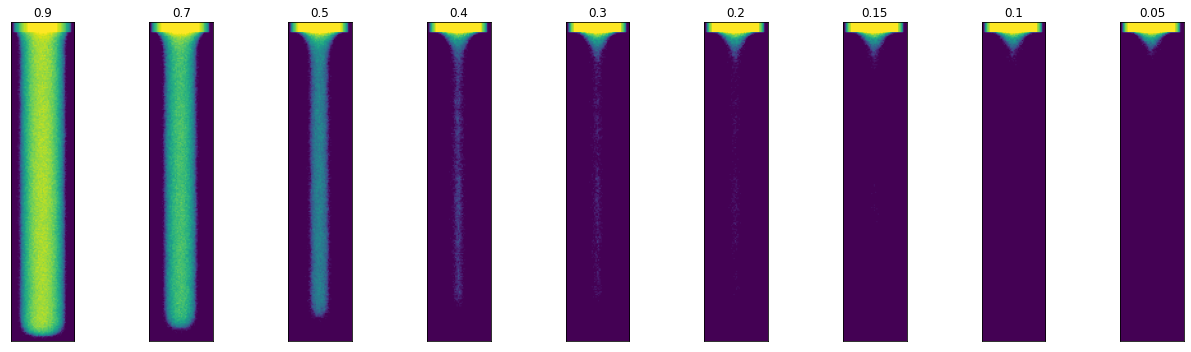

In [68]:
fig = plt.figure()

fig, axs = plt.subplots(nrows=1, ncols=len(savedProjs), figsize=(2*len(savedProjs), 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(len(savedProjs)):
    axs[i].imshow(savedProjs[i], cmap="viridis", vmax=savedProjs[i][wLevel][L//2])
    axs[i].set_title( str(milestones[i]) )

filename="TipL"+str(L)+"H"+str(H)+"a"+str(alpha)+"p"+str(p0)+"cR"+str(cR)+"m"
for miles in milestones:
    filename = filename + "s" + str(miles)
filename=filename+".png"

plt.tight_layout()
plt.savefig(fname=filename)
plt.show(block=True)